In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression


In [2]:
# Joining datasets
train = pd.read_csv('TRAIN (1).csv')
test = pd.read_csv('Test.csv')






train.columns = test.columns

df = pd.concat([train, test])

df.dropna(inplace=True)

In [3]:
# Create time variables
variables = ['d_id', 'evsd', 'quantity_ordered', 'quantity_submitted', 'quantity_received']
df = df[variables]

df['d_id'] = df['d_id'].astype('category')
df['year'] = pd.DatetimeIndex(df['evsd']).year
df['month'] = pd.DatetimeIndex(df['evsd']).month
df['day'] = pd.DatetimeIndex(df['evsd']).day
df['dayofweek'] = pd.DatetimeIndex(df['evsd']).day_name()
df.dayofweek.replace(to_replace=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],value=[0,1,2,3,4,5,6], inplace=True)

In [4]:
df.head()

,d_id,evsd,quantity_ordered,quantity_submitted,quantity_received,year,month,day,dayofweek
0,540,11/14/22,54,54,54,2022,11,14,1
1,540,12/1/22,60,60,60,2022,12,1,4
2,648,10/3/22,6,6,6,2022,10,3,1
3,648,10/17/22,6,6,6,2022,10,17,1
4,7,11/16/22,8,8,8,2022,11,16,3


c:\Users\nshre\anaconda3\envs\auto_gpt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


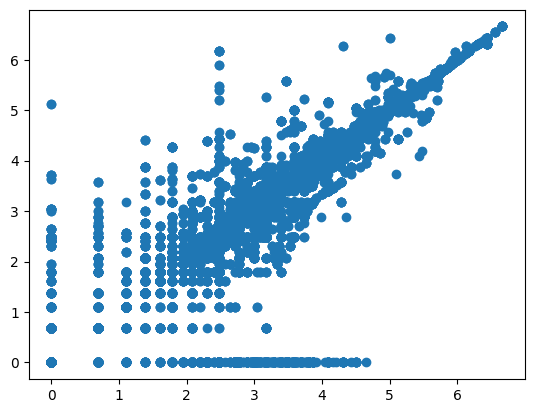

In [5]:
# Scatterplot quantity received vs quantity ordered
plt.plot(np.log(df['quantity_received']), np.log(df['quantity_ordered']), 'o')

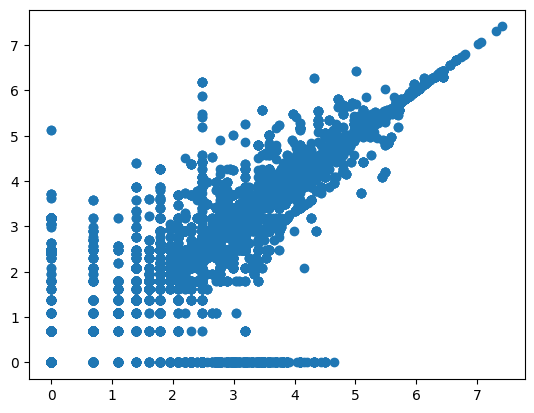

In [6]:
# Scatterplot quantity received vs quantity submitted
plt.plot(np.log(df['quantity_received']), np.log(df['quantity_submitted']), 'o')

In [7]:
# Number of time periods by d_id
df_grouped = df[['d_id', 'evsd']].groupby('d_id').nunique()
df_grouped

,evsd
d_id,
1,57
7,95
13,14
18,13
79,2
110,95
127,7
136,41
174,42


In [8]:
# Filter d_id with more than 10 time periods
ids = list(df_grouped[df_grouped['evsd']>=10].index)
df = df[df['d_id'].isin(ids)]

<Axes: >

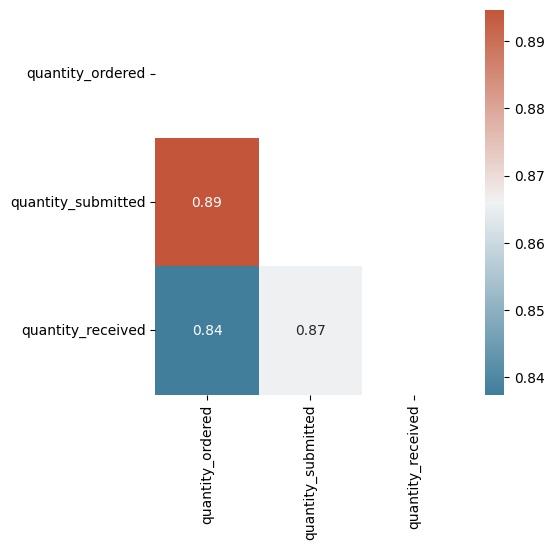

In [9]:
# Correlation matrix
corr = df[['quantity_ordered', 'quantity_submitted', 'quantity_received']].corr()

f, ax = plt.subplots(figsize=(5, 5))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [10]:
df['quantity_received'].describe()

count    356865.000000
mean         13.116156
std          27.293100
min           0.000000
25%           0.000000
50%           6.000000
75%          12.000000
max        1650.000000
Name: quantity_received, dtype: float64

<Axes: >

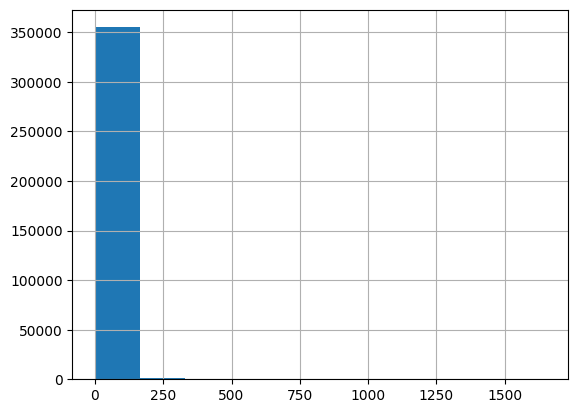

In [11]:
df['quantity_received'].hist()

In [12]:
# Convert time period variables to categorical
for k in ['d_id', 'year', 'month', 'month', 'day', 'dayofweek']:
    df[k] = df[k].astype('category')

In [14]:
# Set strat to split the data
strata = df[['d_id', 'evsd']]

# One hot encoding
# df = pd.get_dummies(df)

In [15]:
df.head()

,d_id,evsd,quantity_ordered,quantity_submitted,quantity_received,year,month,day,dayofweek
0,540,11/14/22,54,54,54,2022,11,14,1
1,540,12/1/22,60,60,60,2022,12,1,4
2,648,10/3/22,6,6,6,2022,10,3,1
3,648,10/17/22,6,6,6,2022,10,17,1
4,7,11/16/22,8,8,8,2022,11,16,3


In [19]:
df.dtypes

d_id                  category
evsd                    object
quantity_ordered         int64
quantity_submitted       int64
quantity_received        int64
year                  category
month                 category
day                   category
dayofweek             category
dtype: object

In [14]:
# Convert dummy variables bool to float
df = df.apply(lambda x: x.astype('float'))

In [15]:
# Reset index 
df.index = range(df.shape[0])

In [16]:
# Data scaling

y = df['quantity_received']
y_mean = np.mean(y)
y_std = np.std(y)

y_scaled = (y - y_mean)/y_std

X = df.drop('quantity_received', axis=1)

X1 = X[['quantity_ordered', 'quantity_submitted']]

X1 = X1.apply(lambda x: (x - np.mean(x))/np.std(x))
X_scaled = pd.concat([X1, X.drop(['quantity_ordered', 'quantity_submitted'], axis=1)], axis=1)

In [17]:
# Train test split
X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42, shuffle=True, stratify=strata)
y_train, y_test = train_test_split(y_scaled, test_size=0.3, random_state=42, shuffle=True, stratify=strata)

## Linear model

In [18]:
lm = LinearRegression()
lm.fit(X_train, y_train)

ValueError: could not convert string to float: '10/15/22'

In [120]:
y_pred = lm.predict(X_test)

# Scale data back
y_test_inv = y_test*y_std + y_mean
y_pred_inv = y_pred*y_std + y_mean

print('R2:', r2_score(y_test_inv, y_pred_inv))
print('MAE:', mean_absolute_error(y_test_inv, y_pred_inv))

R2: 0.8048548227436897
MAE: 5.154412559043304


## Random Forest

In [121]:
rf = RandomForestRegressor(max_depth=2, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [122]:
y_pred = rf.predict(X_test)

# Scale data back
y_test_inv = y_test*y_std + y_mean
y_pred_inv = y_pred*y_std + y_mean

print('R2:', r2_score(y_test_inv, y_pred_inv))
print('MAE:', mean_absolute_error(y_test_inv, y_pred_inv))

R2: 0.6835636870524577
MAE: 7.513149951230406


## Neural Network

In [18]:
# Muestra el progreso del entrenamiento imprimiendo un solo punto para cada época completada
class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

epochs = 1000

In [19]:
# Neural Network arquitechture
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])

In [20]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

In [21]:
# Model training
history = model.fit(
  X_train, y_train,
  epochs=epochs, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

2023-04-28 08:43:22.121244: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [22]:
# Performance metrics by epoch
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.040315,0.090910,0.040315,0.058523,0.096107,0.058523,995
996,0.040339,0.090991,0.040339,0.055204,0.091336,0.055204,996
997,0.040324,0.091153,0.040324,0.059250,0.095675,0.059250,997
998,0.040618,0.091069,0.040618,0.061637,0.098202,0.061637,998
999,0.040424,0.090764,0.040424,0.057644,0.094184,0.057644,999


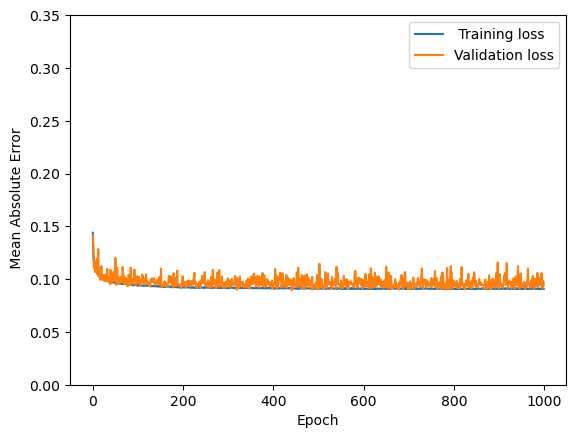

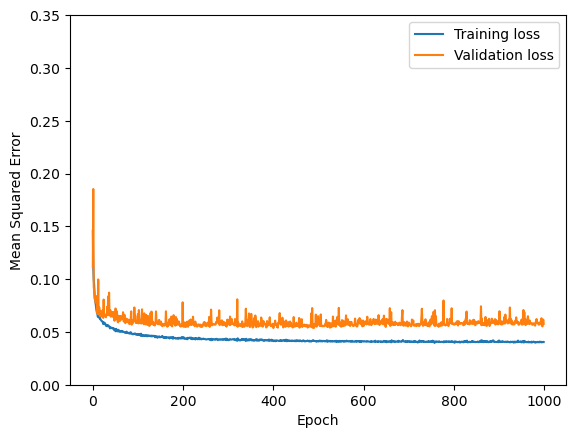

In [23]:
# Loss functions (Validation vs training)
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['Epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(' Mean Absolute Error')
    plt.plot(hist['Epoch'], hist['mae'],
           label=' Training loss')
    plt.plot(hist['Epoch'], hist['val_mae'],
           label = 'Validation loss')
    plt.ylim([0,0.35])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(hist['Epoch'], hist['mse'],
           label='Training loss')
    plt.plot(hist['Epoch'], hist['val_mse'],
           label = 'Validation loss')
    plt.ylim([0,0.35])
    plt.legend()
    plt.show()


plot_history(history)

In [24]:
y_pred = model.predict(X_test)

4266/4266 [==============================] - 1s 313us/step


In [25]:
# Scale data back
y_test_inv = y_test*y_std + y_mean
y_pred_inv = y_pred*y_std + y_mean

print('R2:', r2_score(y_test_inv, y_pred_inv))
print('MAE:', mean_absolute_error(y_test_inv, y_pred_inv))

R2: 0.9466544209504517
MAE: 2.608287288169279


In [36]:
y_test_inv = pd.DataFrame(y_test_inv)
y_test_inv.index = range(y_test_inv.shape[0])

y_pred_inv = pd.DataFrame(y_pred_inv)
y_pred_inv.index = range(y_pred_inv.shape[0])

In [44]:
output = pd.concat([y_test_inv, y_pred_inv], axis=1)

In [46]:
output.columns = ['real', 'predicted']
output.to_excel('')

,quantity_received,0
0,0.0,0.058114
1,12.0,11.875368
2,12.0,9.361361
3,0.0,-0.641523
4,20.0,18.950312
...,...,...
136504,0.0,-0.110303
136505,8.0,8.141498
136506,0.0,-2.546966
136507,8.0,7.110733


In [41]:
len(y_pred_inv)

136509

In [42]:
y_pred_inv

,0
0,0.058114
1,11.875368
2,9.361361
3,-0.641523
4,18.950312
...,...
136504,-0.110303
136505,8.141498
136506,-2.546966
136507,7.110733
